## Imports

In [1]:
from utils import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

## Read/Transform Data

In [2]:
VOCAB_SIZE = 16384
INPUT_LENGTH = 265
NUM_CLASSES = 5

In [3]:
#read data
df = pd.read_csv('cleaned-data.csv')

In [4]:
#join and shuffle data
df = df.sample(frac=1).reset_index(drop=True) #sample shuffles the data
df.head()

,Lyric,Genres
0,the futures counting down gotta get out of it ...,Rock
1,queen of all my sleepless nights for whose bea...,Heavy Metal
2,midnight in the village seeger lights the cand...,Rock
3,dear marshall dear marshall i just wanna start...,Hip Hop
4,pour the wine light revives lowering walls tha...,Rock


In [5]:
indexNames = []
for index, row in df.iterrows():
    if len(row.Genres.split("; "))>1: #or (row.Genres != "Pop" and row.Genres!="Rap"):
        indexNames.append(index)
df = df.drop(indexNames)

In [6]:
"""indexNames = []
counters = dict()
for index, row in df.iterrows():
    if row.Genres in counters:
        if counters[row.Genres]>=15000:
            indexNames.append(index)
        else:
            counters[row.Genres] += 1
    else:
        counters[row.Genres] = 1
df = df.drop(indexNames)"""

'indexNames = []\ncounters = dict()\nfor index, row in df.iterrows():\n    if row.Genres in counters:\n        if counters[row.Genres]>=15000:\n            indexNames.append(index)\n        else:\n            counters[row.Genres] += 1\n    else:\n        counters[row.Genres] = 1\ndf = df.drop(indexNames)'

In [7]:
x = np.array(df['Lyric']) #"text"
y = np.array(df['Genres'])

In [8]:
"""
genres = []

for i in range(len(y)):
    genres.extend(y[i].split("; "))

genres = set(genres)

genre_id = dict()

i=0
for genre in genres:
    genre_id[genre] = i
    i += 1
"""

'\ngenres = []\n\nfor i in range(len(y)):\n    genres.extend(y[i].split("; "))\n\ngenres = set(genres)\n\ngenre_id = dict()\n\ni=0\nfor genre in genres:\n    genre_id[genre] = i\n    i += 1\n'

<AxesSubplot:>

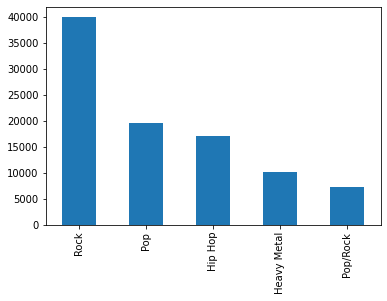

In [9]:
df['Genres'].value_counts().plot.bar()

In [10]:
# tokenizer to transform text into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(x)

#Transforms each text in x to a sequence of integers.
x = tokenizer.texts_to_sequences(x)

#Pads sequences to the same length. In this case, with maxlen of 100 integers
x = pad_sequences(x, maxlen = INPUT_LENGTH)

"""
new_y = []
for string in y:
    new_y.append([0 for _ in range(len(genres))])
    for g in string.split("; "):
        new_y[-1][genre_id[g]]=1

y = np.array(new_y)
"""

# tokenizer to transform text into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split='; ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(y)

#Transforms each text in x to a sequence of integers.
y = tokenizer.texts_to_sequences(y)

y = np.array([elem[0]-1 for elem in y])

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = split(x, y)

## Model

In [12]:
def LSTM_Model(features=512, dropout=0.7, neurons=256):
    model=Sequential()
    # Embedding layer
    model.add(Embedding(VOCAB_SIZE,features,input_length=INPUT_LENGTH))
    # Long Short Term Memory layer
    model.add(LSTM(neurons, dropout=dropout))
    # Output layer
    model.add(Dense(NUM_CLASSES,activation='sigmoid'))
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [13]:
model = LSTM_Model()
model.summary()

2022-07-04 14:34:15.591045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 14:34:23.091597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 14:34:23.092672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 14:34:23.138088: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 512)          8388608   
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 9,177,349
Trainable params: 9,177,349
Non-trainable params: 0
_________________________________________________________________


## Validation and Testing

In [14]:
epochs = 3

results = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=epochs)

Epoch 1/3


2022-07-04 14:35:10.993940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1762/1762 [==============================] - 194s 96ms/step - loss: 1.0061 - accuracy: 0.5525 - val_loss: 0.8144 - val_accuracy: 0.6485
Epoch 2/3
1762/1762 [==============================] - 168s 95ms/step - loss: 0.7324 - accuracy: 0.6863 - val_loss: 0.7561 - val_accuracy: 0.6853
Epoch 3/3
1762/1762 [==============================] - 180s 102ms/step - loss: 0.6110 - accuracy: 0.7479 - val_loss: 0.7449 - val_accuracy: 0.6907


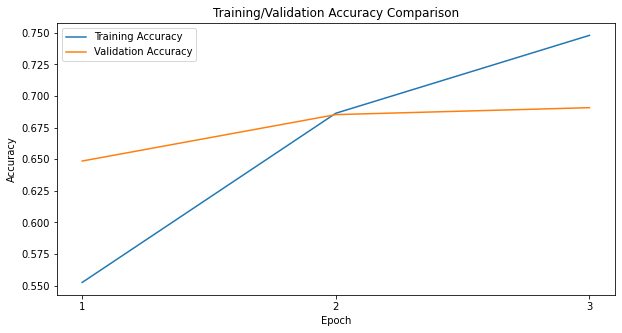

In [15]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

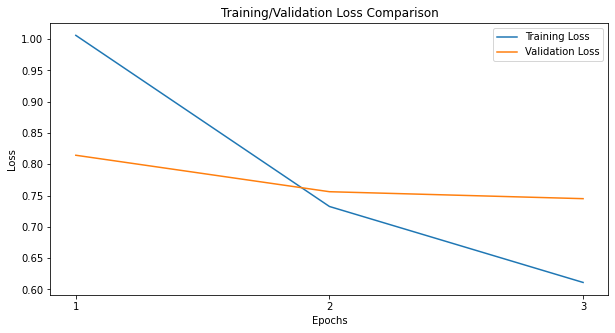

In [16]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

In [17]:
model = LSTM_Model()
results = model.fit(np.concatenate((x_train,x_val)), np.concatenate((y_train,y_val)), epochs=epochs)
loss, acc = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

# show confusion matrix
y_pred=np.argmax(model.predict(x_test), axis=-1)
#plot_confusion_matrix(y_test, y_pred)

# show other metrics
print(classification_report(y_pred,y_test))

Epoch 1/3
2350/2350 [==============================] - 243s 103ms/step - loss: 0.9322 - accuracy: 0.5837
Epoch 2/3
2350/2350 [==============================] - 243s 103ms/step - loss: 0.6932 - accuracy: 0.7044
Epoch 3/3
588/588 [==============================] - 21s 35ms/step - loss: 0.7068 - accuracy: 0.7048
Test Loss: 0.7067761421203613
Test Accuracy: 0.7047836780548096
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      9257
           1       0.54      0.63      0.58      4589
           2       0.80      0.88      0.84      3124
           3       0.65      0.72      0.68      1823

    accuracy                           0.70     18793
   macro avg       0.70      0.73      0.71     18793
weighted avg       0.72      0.70      0.71     18793



## Hyper-Parameter Selection

### Epochs

In [18]:
model = LSTM_Model()
results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=10)

Epoch 1/10
1762/1762 [==============================] - 200s 112ms/step - loss: 0.9834 - accuracy: 0.5614 - val_loss: 0.8343 - val_accuracy: 0.6303
Epoch 2/10
1762/1762 [==============================] - 200s 114ms/step - loss: 0.7323 - accuracy: 0.6871 - val_loss: 0.7484 - val_accuracy: 0.6772
Epoch 3/10
1762/1762 [==============================] - 203s 115ms/step - loss: 0.6123 - accuracy: 0.7458 - val_loss: 0.7433 - val_accuracy: 0.6902
Epoch 4/10
1762/1762 [==============================] - 197s 112ms/step - loss: 0.5180 - accuracy: 0.7886 - val_loss: 0.7948 - val_accuracy: 0.6838
Epoch 5/10
1762/1762 [==============================] - 205s 117ms/step - loss: 0.4380 - accuracy: 0.8245 - val_loss: 0.8467 - val_accuracy: 0.6755
Epoch 6/10
1762/1762 [==============================] - 213s 121ms/step - loss: 0.3728 - accuracy: 0.8526 - val_loss: 0.9553 - val_accuracy: 0.6704
Epoch 7/10
1762/1762 [==============================] - 200s 114ms/step - loss: 0.3178 - accuracy: 0.8784 - val_

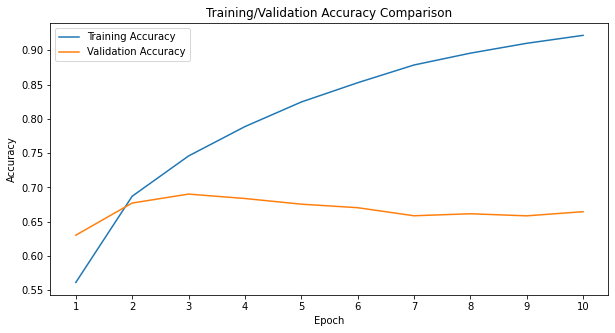

In [19]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

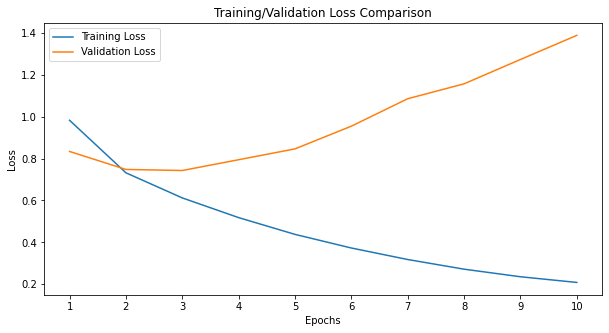

In [20]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

### Dropout Rate

In [ ]:
dropout_rates=[]
acc = []
loss = []

dp = 0
while dp <= 0.9:
    model = LSTM_Model(dropout=dp)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    dropout_rates.append(dp)
    dp += 0.1

Epoch 1/3
1762/1762 [==============================] - 188s 105ms/step - loss: 0.9464 - accuracy: 0.5765 - val_loss: 0.8169 - val_accuracy: 0.6166
Epoch 2/3
1762/1762 [==============================] - 184s 105ms/step - loss: 0.6928 - accuracy: 0.7055 - val_loss: 0.7432 - val_accuracy: 0.6845
Epoch 3/3
1762/1762 [==============================] - 200s 114ms/step - loss: 0.5651 - accuracy: 0.7663 - val_loss: 0.7686 - val_accuracy: 0.6871
Epoch 1/3
1762/1762 [==============================] - 214s 120ms/step - loss: 0.9462 - accuracy: 0.5795 - val_loss: 0.7932 - val_accuracy: 0.6634
Epoch 2/3
1762/1762 [==============================] - 210s 119ms/step - loss: 0.6964 - accuracy: 0.7037 - val_loss: 0.7501 - val_accuracy: 0.6792
Epoch 3/3
1762/1762 [==============================] - 214s 121ms/step - loss: 0.5649 - accuracy: 0.7650 - val_loss: 0.7733 - val_accuracy: 0.6875
Epoch 1/3
1762/1762 [==============================] - 215s 121ms/step - loss: 0.9592 - accuracy: 0.5713 - val_loss: 0

In [ ]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", dropout_rates)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", dropout_rates)

### Features

In [ ]:
features=[]
acc = []
loss = []

f = 32
while f <= 512:
    model = LSTM_Model(features=f)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    features.append(f)
    f *= 2

In [ ]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", features)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", features)

### Neurons

In [ ]:
neurons=[]
acc = []
loss = []

n = 32
while n <= 512:
    model = LSTM_Model(neurons=n)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    neurons.append(n)
    n *= 2

In [ ]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", neurons)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", neurons)